In [1]:
import sys
print(f'Interpreter dir: {sys.executable}')
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
print(f'Working dir: {os.getcwd()}')
%load_ext autoreload
%autoreload 2

Interpreter dir: /Users/jsg/Documents/GitHub/water_hackathlon/.venv_waterhack/bin/python3
Working dir: /Users/jsg/Documents/GitHub/water_hackathlon


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold,cross_val_score,ShuffleSplit,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report

from scipy.stats import randint,uniform
import lightgbm as lgb

from waterhack.visualize import time_vs_y
from waterhack.utils import find_col
from waterhack.utils import series_to_supervised

# Baseline model

Lets load the dataset, add a few new columns and apply a simple baseline model

Some of the measurements are clearly wrong: for example, cases of negative inflow. We should find some rules to discard those datapoints.

---


In [3]:
df = pd.read_csv('data/processed/DMAVolumePressureWeather.csv', sep=",",parse_dates = ['Timestamp','DateRaised'])
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943668 entries, 0 to 943667
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DMA           943668 non-null  object        
 1   Timestamp     943668 non-null  datetime64[ns]
 2   PressureBar   943668 non-null  float64       
 3   m3Volume      943668 non-null  float64       
 4   DateRaised    962 non-null     datetime64[ns]
 5   LeakType      962 non-null     object        
 6   DMAName       962 non-null     object        
 7   is_leakage    943668 non-null  int64         
 8   maxtempC      943668 non-null  int64         
 9   mintempC      943668 non-null  int64         
 10  totalSnow_cm  943668 non-null  float64       
 11  sunHour       943668 non-null  float64       
 12  uvIndex       943668 non-null  int64         
 13  DewPointC     943668 non-null  int64         
 14  humidity      943668 non-null  int64         
 15  precipMM      943

DMA  Timestamp  PressureBar  m3Volume DateRaised LeakType  \
0       NEWSEVMA 2016-12-01     2.011256    11.210        NaT      NaN   
1       NORW21MA 2016-12-01     2.345946     8.094        NaT      NaN   
2       NEWSTUMA 2016-12-01     2.564902     0.000        NaT      NaN   
3       BURYRDMA 2016-12-01     2.208337     2.650        NaT      NaN   
4       NORW37MA 2016-12-01     2.514855     2.791        NaT      NaN   
...          ...        ...          ...       ...        ...      ...   
943663  NORFIFMA 2020-06-01     0.000000     3.375        NaT      NaN   
943664  NORCRDMA 2020-06-01     1.698159     2.077        NaT      NaN   
943665  NEWSTUMA 2020-06-01     2.667152     2.300        NaT      NaN   
943666  NORW37MA 2020-06-01     2.570253     1.598        NaT      NaN   
943667  SWALSHMA 2020-06-01     0.000000     0.000        NaT      NaN   

       DMAName  is_leakage  maxtempC  mintempC  totalSnow_cm  sunHour  \
0          NaN           0         7         3           0.0      6.8   
1          NaN           0         7         3           0.0      6.8   
2          NaN           0         7         3           0.0      6.8   
3          NaN           0         7         3           0.0      6.8   
4          NaN           0         7         3           0.0      6.8   
...        ...         ...       ...       ...           ...      ...   
943663     NaN           0        18        10           0.0     16.7   
943664     NaN           0        18        10           0.0     16.7   
943665     NaN           0        18        10           0.0     16.7   
943666     NaN           0        18        10           0.0     16.7   
943667     NaN           0        18        10           0.0     16.7   

        uvIndex  DewPointC  humidity  precipMM  pressure  tempC  
0             2          3        95       0.0      1031      4  
1             2          3        95       0.0      1031      4  
2             2          3        95       0.0      1031      4  
3             2          3        95       0.0      1031      4  
4             2          3        95       0.0      1031      4  
...         ...        ...       ...       ...       ...    ...  
943663        5         10        95       0.0      1026     10  
943664        5         10        95       0.0      1026     10  
943665        5         10        95       0.0      1026     10  
943666        5         10        95       0.0      1026     10  
943667        5         10        95       0.0      1026     10  

[943668 rows x 18 columns]

In [5]:
df.LeakType.value_counts()

Other Repaired Leaks              383
Comm Pipe (before ST)              97
BurstMain                          88
BTBB                               77
Fire Hydrant (Fixed On Site)       59
Stop Tap / Atplas                  55
Main up to 6" (150mm)              37
Meter (Fixed On Site)              36
BTBB (Low Level)                   20
Ferrule                            20
Sluice Valve                       15
Fire Hydrant                       15
Washout (Fixed On Site)            15
Meter                              11
Stop Tap/ Atplas (Fix On Site)     10
Washout                             9
Unrecorded Consumption (Sml)        6
Sluice Valve (Fixed On Site)        4
Main 12" (300mm) and above          2
Main >6" (150mm) <12" (300mm)       2
Serv Pipe (after ST not BTBB)       1
Name: LeakType, dtype: int64

In [62]:
def process_dma(df_filt):
    
    # Delete rows with "big enough" negative inflow
    df_filt = df_filt[df_filt.m3Volume > 0]
    
    # Add new columns manually
    df_filt['tempRange'] = df_filt['maxtempC'] - df_filt['mintempC']
    df_filt['ratioVolPres'] = df_filt['m3Volume'] - df_filt['PressureBar']
    
    # Add hour and day of week indicator
    df_filt['hour'] = df_filt['Timestamp'].dt.hour
    df_filt['dayofweek'] = df_filt['Timestamp'].dt.dayofweek

    # TODO: add MNF and average as well
    
    # Set index time -> needed for time-rolling
    df_filt = df_filt.set_index('Timestamp',drop=False)
    
    # Add rolling mean
    rol_col = {'PressureBar':["1h","2h","12h","24h"],
               'm3Volume':["1h","2h","12h","24h"],
               'tempRange':["2h","24h"],
               "ratioVolPres":['1h',"2h","12h","24h"]
              }
    ma_cols = []
    for c in rol_col.keys():
        for w in rol_col[c]:
            new_col = f'{c}_MA{w}'
            ma_cols.append(new_col)
            df_filt[new_col] = df_filt[c].rolling(window=w).mean()
            
    
    # Add past values of pressure and volume
    lagged_cols = find_col(df_filt, 'Pressure*') + find_col(df_filt, 'm3Volume*')+ find_col(df_filt, 'ratioVolPres*')
#     print(f"Lagging columns: {lagged_cols}")

    df_lag, names_in, names_out = series_to_supervised(df_filt, lagged_cols = lagged_cols, n_in = [1,2,4,6,8,12,24*4])

#     print(f"Resulting new columns:\n{names_in}")
#     print(f"Columns not modified:\n{names_out}")
    print(f"Shape lagged dataset: {df_lag.shape}")
    
    return df_lag 

In [63]:
import warnings
warnings.filterwarnings('ignore')

df_lag_list = []

for dma in df.DMA.unique():
    print(dma)
    df_filt = df[df.DMA == dma]
    df_lag_list.append(process_dma(df_filt))
    
df_lag = pd.concat(df_lag_list)
df_lag.shape

NEWSEVMA
Shape lagged dataset: (115847, 141)
NORW21MA
Shape lagged dataset: (108288, 141)
NEWSTUMA
Shape lagged dataset: (113539, 141)
BURYRDMA
Shape lagged dataset: (122531, 141)
NORW37MA
Shape lagged dataset: (120984, 141)
NEWCENMA
Shape lagged dataset: (122173, 141)
NORFIFMA
Shape lagged dataset: (41536, 141)
SWALSHMA
Shape lagged dataset: (12160, 141)
NORW18MA
Shape lagged dataset: (22206, 141)
NORCRDMA
Shape lagged dataset: (41441, 141)
BLOFLDMA
Shape lagged dataset: (41504, 141)


(862209, 141)

In [57]:
find_col(df_lag, 'm3Volume*-1\)')

[]

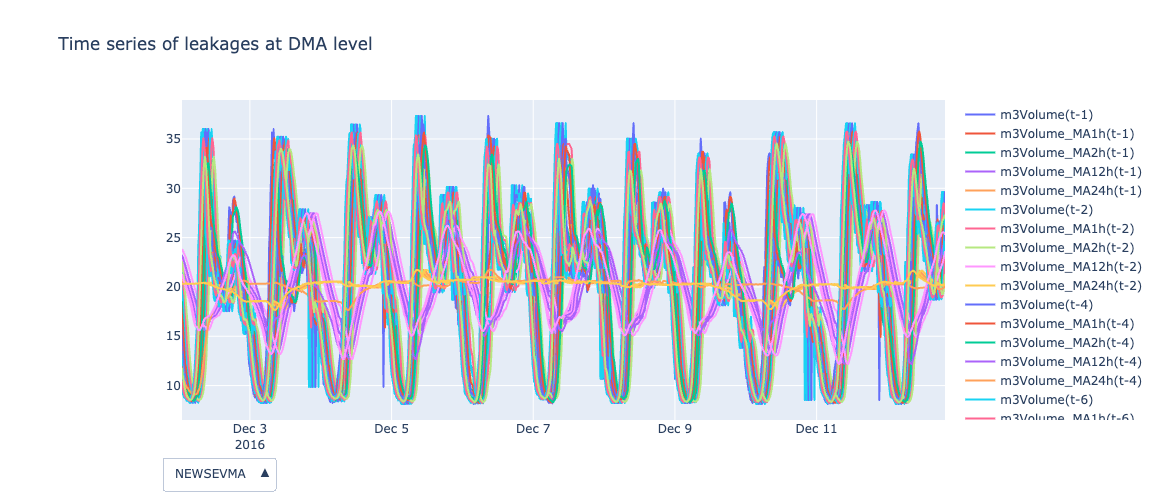

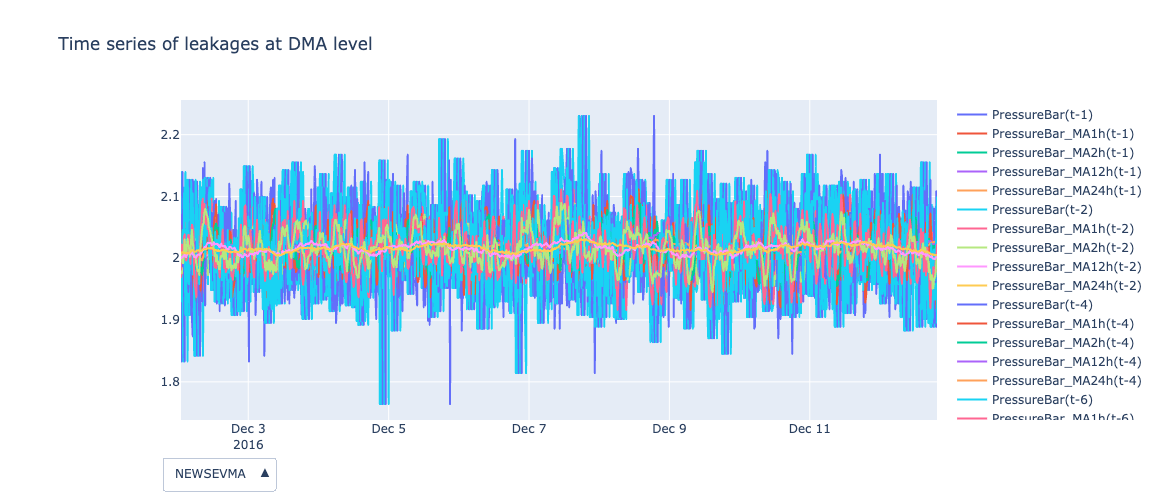

In [64]:
fig = time_vs_y(df = df_lag[:1000],
          time_col = 'Timestamp',
         id_col_name = 'DMA',
         id_list =df.DMA.unique(),
         cols_descr = find_col(df_lag, 'm3Volume*'),
          y_col = 'is_leakage',
         title='Time series of leakages at DMA level')
fig.show()

fig = time_vs_y(df = df_lag[:1000],
          time_col = 'Timestamp',
         id_col_name = 'DMA',
         id_list =df.DMA.unique(),
         cols_descr = find_col(df_lag, 'Pressure*'),
          y_col = 'is_leakage',
         title='Time series of leakages at DMA level')
fig.show()

# Quick exploration

In [11]:
ProfileReport(df_lag, title="Profiling of training dataset",progress_bar=False,minimal=True).to_widgets()

# Build baseline model

Shape X_train before undersampling: (662208, 92)
Shape y_train before undersampling: (662208, 1)
Shape X_train after undersampling: (5319, 92)
Shape y_train after undersampling: (5319, 1)
Shape X_test: (200000, 92)
Shape y_test: (200000, 1)


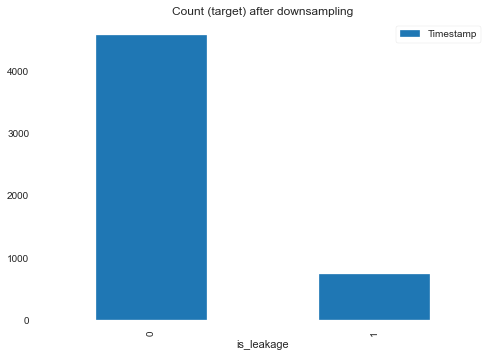

In [81]:
# Sample training dataset
def prepare_dataset(
    df,
    x_cols,
    y_col,
    fix_imbalance,
    ratio_imbalance=60 / 40,
    do_plot=False,
    return_X_fp=False,
):
    """Funcion para preparar el dataset. Usamos el mes de Octubre como test.
    
    df : pd.DataFrame
    x_cols : list of str
        features
    y_col : list
        Target col
    fix_imbalance : bool
        True: 
        Fix imbalance by sampling training set
    ratio_imbalance : float 
        Ratio between 0 and 1 in the train set
    do_plot : bool
        Hacer un grafico o no
    return_X_fp : bool
        Si hacemos balanceo, devolvemos tambien el dataset de X que hemos descartado, para usarlo de test e identificar falsos positivos
        
    """
    
    # Separate train and test. Lets keep the last 10k obs as test
    n_obs_test = 200000
    N = df.shape[0]

    idx_train = range(0,N-n_obs_test-1)
    idx_test = range(N-n_obs_test,N)

    X_train = df[x_cols].iloc[idx_train]
    X_test = df[x_cols].iloc[idx_test]

    y_train = df[y_col].iloc[idx_train]
    y_test = df[y_col].iloc[idx_test]

    if fix_imbalance == True:
        # Balance dataset

        if do_plot:
            print(f"Shape X_train before undersampling: {X_train.shape}")
            print(f"Shape y_train before undersampling: {y_train.shape}")

        # Undersample the trainning set so that there are same number of 0 than 1
        # Selecciono los indices con 0
        idx_0 = y_train[y_train[y_col[0]] == 0].dropna().index.values
        # Selecciono los indices con 1 (clase minoritaria)
        idx_1 = y_train[y_train[y_col[0]] == 1].dropna().index.values
        # Elijo un sample de los ceros
        keep_indices_0 = np.random.choice(
            idx_0, int(ratio_imbalance * len(idx_1)), replace=False
        )
        keep_indices = np.concatenate((keep_indices_0, idx_1))

        # Me quedo con los indices de train que son 0, pero que no hemos elegido
        X_train_false = X_train.loc[~X_train.index.isin(keep_indices),].copy()
        X_train = X_train.loc[X_train.index.isin(keep_indices),].copy()
        y_train = y_train.iloc[y_train.index.isin(keep_indices),].copy()

        y_train_false = y_train.loc[
            ~y_train.index.isin(keep_indices),
        ].copy()  ### TESTING
        assert np.sum(y_train_false.values != 0) == 0, "y_train_false != 0 "

        if do_plot:
            print(f"Shape X_train after undersampling: {X_train.shape}")
            print(f"Shape y_train after undersampling: {y_train.shape}")
            target_count = y_train.reset_index().groupby(y_col[0]).count()
            target_count.plot(kind="bar", title="Count (target) after downsampling")
    
    else:
        print(f'Shape X_train: {X_train.shape}')
        print(f'Shape y_train: {y_train.shape}')
        
    print(f'Shape X_test: {X_test.shape}')
    print(f'Shape y_test: {y_test.shape}')
    
    if return_X_fp == False or fix_imbalance == False:
        return X_train, y_train, X_test, y_test
    else:
        return X_train, y_train, X_test, y_test, X_train_false
    
    
# Define relevant columns
df = df_lag # TODO: change
#df = df.set_index('Timestamp')
x_cat_cols = [ 'hour','dayofweek']
x_num_cols = find_col(df, 'Pressure*') + find_col(df, 'm3Volume*') + ['maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'DewPointC', 'humidity', 'precipMM', 'pressure','tempC']
x_cols = x_cat_cols + x_num_cols
y_col = ['is_leakage']

# Splot data
X_train, y_train, X_test, y_test = prepare_dataset(
    df = df,
    x_cols = x_cols,
    y_col = y_col,
    fix_imbalance = True,
    ratio_imbalance=1 / 3,
    do_plot=True,
    return_X_fp=False,
)

In [82]:
print(y_train.is_leakage.sum())
print(y_test.is_leakage.sum())


739
198


In [70]:
# Define parameters
params = {
        'n_estimators': randint(100, 500),
#         'learning_rate': 0.01,
        #'gamma': [1,5],
        #'subsample': uniform(0.5,9), # bagging_fraction
        #'colsample_bytree': [0.3, 0.5],
#         'max_depth': [10] #randint(2, 15)
    'max_bin':[30,50,100],
    'num_leaves':[5,12,31]
        }
# Split training set into validation
#cv_ss = TimeSeriesSplit(n_splits=10).split(X_train, y_train)
cv_ss = StratifiedKFold(n_splits=5).split(X_train, y_train)


# Define model
gbm = lgb.LGBMClassifier(objective='binary',metric='binary',bagging_fraction=0.5,
                         categorical_features = x_cat_cols,
                        is_unbalance=True)
#                          scale_pos_weight = 99) # TODO


n_iter = 30 # Max numero de iteraciones
random_search = RandomizedSearchCV(gbm, param_distributions=params,
                                   n_iter = n_iter, n_jobs=2,
                                   scoring = "f1_macro",
                                   cv = cv_ss, verbose=10, random_state=1234 )
# Fit xgb
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   20.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   26.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   34.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   41.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   50.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  2.3min
[Parallel(

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fa481aa9ed0>,
                   estimator=LGBMClassifier(bagging_fraction=0.5,
                                            categorical_features=['hour',
                                                                  'dayofweek'],
                                            is_unbalance=True, metric='binary',
                                            objective='binary'),
                   n_iter=30, n_jobs=2,
                   param_distributions={'max_bin': [30, 50, 100],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1ceaae810>,
                                        'num_leaves': [5, 12, 31]},
                   random_state=1234, scoring='f1_macro', verbose=10)

# Model validation

In [71]:
print('\n Best hyperparameters:')
print(random_search.best_params_)
gbm_model = random_search.best_estimator_
print('Best model:')
print(gbm_model)

# Collect GridSearch CV results. Get the best estimator.
df_results = pd.DataFrame(random_search.cv_results_)
err = df_results[df_results.rank_test_score == 1].filter(regex=("split\d.*")).values
display(err)


 Best hyperparameters:
{'max_bin': 30, 'n_estimators': 196, 'num_leaves': 5}
Best model:
LGBMClassifier(bagging_fraction=0.5, categorical_features=['hour', 'dayofweek'],
               is_unbalance=True, max_bin=30, metric='binary', n_estimators=196,
               num_leaves=5, objective='binary')


array([[0.26283487, 0.43604225, 0.50779031, 0.34590157, 0.61367571]])

In [72]:
y_train_pred = gbm_model.predict(X_train)
y_test_pred = gbm_model.predict(X_test)

print("TRAIN dataset")
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

print("TEST DATSET")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


TRAIN dataset
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     20060
           1       0.20      0.93      0.33       935

    accuracy                           0.83     20995
   macro avg       0.60      0.88      0.62     20995
weighted avg       0.96      0.83      0.88     20995

[[16589  3471]
 [   61   874]]
TEST DATSET
[[8594 1404]
 [   2    0]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      9998
           1       0.00      0.00      0.00         2

    accuracy                           0.86     10000
   macro avg       0.50      0.43      0.46     10000
weighted avg       1.00      0.86      0.92     10000



### Quick conclusion and notes

- The model is overfitting, need wo work on that
- Does not capture well the relationships
- Need to work on cleaning the data
- There is a huge imbalance. We need to do something smart about the zeros.
    - Think about a better way of doing this. Maybe aggregate the DMA's together? Maybe sample only around the leakage time?
- Am I doing the CV correctly? IF there are information leakage?
- The model does not capture well the relationships
    - Add more features (time-related)
    - Add info from SMartMeter txt files
- Shall we predict instead if there will be a leakage in the next 24h, for example?